In [117]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
import textwrap

%matplotlib inline

In [2]:
df = (pd.read_csv('data/rand.csv', parse_dates = ['date'])
        .drop(columns = 'Unnamed: 0', axis = 1))
df.head()

,date,amount,bal
0,2017-01-29,60.0,696.4
1,2017-01-29,200.0,896.4
2,2017-01-29,-39.9,856.5
3,2017-01-29,-95.0,761.5
4,2017-01-30,410.0,1171.5


In [3]:
trace = go.Scatter(x = df.index, 
                   y = df['amount'])

data = [trace]

plotly.plotly.iplot(data, filename = 'basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~racpo6/0 or inside your plot.ly account where it is named 'basic-line'


/Users/Rachel/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [4]:
plotly.offline.plot({'data': [go.Scatter(x=df.date, y=df.amount)],
                     'layout': go.Layout(title="Hi Rachel")},
                      auto_open=True)

'temp-plot.html'

In [5]:
daily = df.groupby('date')[['amount', 'bal']].agg({'amount':'sum', 'bal':'last'})
daily

plotly.offline.plot({'data': [go.Scatter(x = daily.index, 
                                         y = daily.amount)],
                     'layout': go.Layout(title = "Daily spend")})

'temp-plot.html'

In [6]:
spend = (df.copy()
          .loc[df['amount']<0]
          .reset_index(drop=True)
          .assign(cumulative_annual = lambda x: x.groupby(x['date'].dt.year)['amount'].cumsum(),
                  cumulative_month = lambda x: x.groupby(x['date'].dt.month)['amount'].cumsum()))
spend.head()

,date,amount,bal,cumulative_annual,cumulative_month
0,2017-01-29,-39.90,856.50,-39.90,-39.90
1,2017-01-29,-95.00,761.50,-134.90,-134.90
2,2017-01-30,-410.00,761.50,-544.90,-544.90
3,2017-01-30,-40.15,721.35,-585.05,-585.05
4,2017-01-30,-25.85,695.50,-610.90,-610.90


In [7]:
daily_spend = (df.copy()
                 .loc[df['amount']<0]
                 .groupby('date')[['amount', 'bal']].agg({'amount':'sum', 'bal':'last'})
                 .reset_index()
                 .assign(cumulative_annual = lambda x: x.groupby(x['date'].dt.year)['amount'].cumsum(),
                         cumulative_month = lambda x: x.groupby(x['date'].dt.to_period('M'))['amount'].cumsum(), 
                         month = lambda x: x['date'].dt.to_period('M'), 
                         day = lambda x: x['date'].dt.day))

daily_spend.loc[daily_spend['date']=='2019-01-01']

,date,amount,bal,cumulative_annual,cumulative_month,month,day
550,2019-01-01,-74.65,258.68,-74.65,-74.65,2019-01,1


,This month to date,Last month,past_12_months_average
day,,,
27,NaN,8772.58,11653.117500
28,NaN,8772.58,12191.210833
29,NaN,8772.58,12236.251667
30,NaN,8893.69,12526.500833
31,NaN,NaN,12796.836667


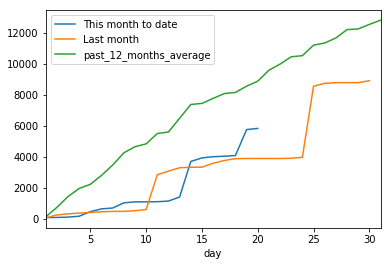

In [149]:
data = (daily_spend.pivot_table(values = 'cumulative_month', index = 'day', columns = 'month', aggfunc = 'sum')
                   .multiply(-1)
                   .replace(np.nan, method = 'ffill')
                   .assign(average_past_12_months = lambda x: x[x.columns[-12:]].mean(axis=1)))
data.columns = data.columns.astype('str')

report_data = data.copy()[data.columns[-3:]]
report_data.columns = ['2019-04', '2019-03', 'past_12_months_average']
report_data = report_data.rename(columns = {'2019-04': 'This month to date', '2019-03': 'Last month', 'annual_average': 'Average month'})

# Set some values to np.nan for authenticity - as if the month hasn't finished
report_data.loc[21:, 'This month to date'] = np.nan

# Manually remove April 31 - work out the proper way to do this
report_data.loc[31, 'Last month'] = np.nan

report_data.plot(kind = 'line');

report_data.tail()

In [124]:
x = 'This is a very long title and it would be great to have it on three lines'

split_text = textwrap.wrap('{}'.format(x), width=50)
split_text

['This is a very long title and it would be great to',
 'have it on three lines']

In [170]:
import plotly.plotly as py
import plotly.graph_objs as go

# Properties
labels = ['This month to date', 'Last month', 'Average month']
colours = ['rgb(98, 29, 75)', 'rgb(61, 72, 73)', 'rgb(189,189,189)']
mode_size = [12, 8, 8]
line_size = [4, 2, 2]

# Add data 
traces = []

for i in range(len(labels)):
    traces.append(go.Scatter(x = report_data.index, 
                             y = report_data[report_data.columns[i]], 
                             name = labels[i],
                             mode = 'lines', 
                             line = dict(color = colours[i], 
                                         width = line_size[i]),
                             connectgaps=True))
    
for i in range(len(labels)):
    traces.append(go.Scatter(x= [report_data[report_data.columns[i]].idxmax()],
                             y= [report_data[report_data.columns[i]].max()],
                             hoverinfo = 'skip',
                             mode='markers',
                             marker= dict(color=colours[i], 
                                          size=mode_size[i])))

# Add layout
layout = go.Layout(xaxis = dict(showline=True,
                                showgrid=False,
                                showticklabels=True,
                                linecolor='rgb(204, 204, 204)',
                                linewidth=2,
                                ticks='outside',
                                tickcolor='rgb(204, 204, 204)',
                                tickwidth=2,
                                ticklen=5,
                                tickfont=dict(family='Arial',
                                              size=12,
                                              color='rgb(82, 82, 82)')),
                   yaxis = dict(showline=True,
                                showgrid=False,
                                zeroline=False,
                                hoverformat = '$,.2f',
                                showticklabels=True,
                                linecolor='rgb(204, 204, 204)',
                                linewidth=2,
                                ticks='outside',
                                tickcolor='rgb(204, 204, 204)',
                                tickwidth=2,
                                ticklen=5,
                                tickfont=dict(family='Arial',
                                              size=12,
                                              color='rgb(82, 82, 82)')),
                    autosize = False,
                    margin = dict(autoexpand=False, 
                                  l=100,
                                  r=100,
                                  t=100,
                                  b=100),
                   showlegend=False)

annotations = []

# Title
annotations.append(dict(xref='paper', #reference point to measure x from - 'paper' means the edges 
                        yref='paper', 
                        x=0.0, 
                        y=1.2,
                        xanchor='left', 
                        yanchor='bottom',
                        text='Spend comparison',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(61, 72, 73)'),
                        showarrow=False))
# Note
annotations.append(dict(xref='paper', 
                        yref='paper', 
                        x=0, 
                        y=-0.2,
                        xanchor='left',
                        yanchor='top',
                        text='Note: All data is fabricated. This project was created in 2019.',
                        font=dict(family='Arial',
                                  size=12,
                                  color='rgb(150,150,150)'),
                                  showarrow=False))

# # Line labels
for i in range(len(labels)):
    annotations.append(dict(xref='paper', 
                            x=0.95, 
                            y=report_data[report_data.columns[i]].max(),
                            xanchor='left', 
                            yanchor='middle',
                            text='${0:,.2f}'.format(report_data[report_data.columns[i]].max()),
                            font=dict(family='Arial',
                                      size=16, 
                                      color = colours[i]),
                            showarrow=False))
    
for i in range(len(labels)):
    annotations.append(dict(xref='paper', 
                            x=0.95, 
                            y=report_data[report_data.columns[i]].max() + 1000,
#                             y=report_data[report_data.columns[i]].max() + (report_data.max().max() * 0.1),
                            xanchor='left', 
                            yanchor='middle',
                            text=labels[i],
                            font=dict(family='Arial',
                                      size=12, 
                                      color = colours[i]),
                            showarrow=False))

layout['annotations'] = annotations # This adds the annotations to the layout dictionary - otherwise gets a bit unwieldy

fig = go.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='spend-comparison.html')

'spend-comparison.html'

In [162]:
traces

[Scatter({
     'connectgaps': True,
     'line': {'color': 'rgb(98, 29, 75)', 'width': 4},
     'mode': 'lines',
     'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
     'y': array([  70.54,   78.72,   99.2 ,  157.67,  452.73,  631.7 ,  684.9 , 1018.83,
                 1083.04, 1083.04, 1093.54, 1134.56, 1397.04, 3688.63, 3918.65, 3995.82,
                 4026.62, 4070.82, 5744.83, 5820.61,     nan,     nan,     nan,     nan,
                     nan,     nan,     nan,     nan,     nan,     nan,     nan])
 }), Scatter({
     'connectgaps': True,
     'line': {'color': 'rgb(61, 72, 73)', 'width': 2},
     'mode': 'lines',
     'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
     'y': array([  47.82,  239.42,  309.71,  358.17,  400.59,  445.12,  468.32,  472.82,
           

In [126]:
test = pd.DataFrame({'2017': [300, 400, 420], 
                     '2018': [150, 170, 510]},
                     index = ['1-Jan', '2-Jan', '3-Jan'])
test

,2017,2018
1-Jan,300,150
2-Jan,400,170
3-Jan,420,510


In [138]:
trace0 = go.Scatter(x = test.index, 
                   y = test['2017'], 
                   name = '2017', 
                   line = dict(color = ('rgb(147,147,147)'), 
                           width = 2))
trace1 = go.Scatter(x = test.index, 
                   y = test['2018'], 
#                    mode = 'lines', 
                   name = '2018', 
                   line = dict(color = ('rgb(0,0,0)'), 
                           width = 4))

plotly.offline.plot({'data': [trace0, trace1],
                     'layout': go.Layout(title="Hi Rachel")},
                      auto_open=True)

'temp-plot.html'